# Libraries

In [198]:
import pandas as pd
import numpy  as np
import string 
import re
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
# import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# #from nltk.tokenize.treebank import TreebankWordDetokenizer
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
#from nltk.corpus import stopwords

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

print('Done')



Done


# Data

In [159]:
pd.set_option('max_colwidth', None) 
df = pd.read_csv("~/Downloads/banData/MeTooHate.csv")[["text", "category"]]
#df.head()

## Undersample data

In [160]:
df1 = df[df["category"]== 1]
df1 = df[df["category"]== 1].dropna()
df0 = df[df["category"]== 0].dropna()
df = pd.concat([df0.sample(df1.shape[0]), df1], axis = 0)


#shuffle rows
df = df.sample(frac=1)
df.shape
df.reset_index(inplace = True)

df = df.head(100)

In [161]:
y = df["category"]
X = df.drop(columns = ["category"]) 

In [162]:
#df.head()

## Clean data

In [163]:
def clean_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
   
    # tokenize + remove scpecial characters + set to lower case
    data = text_to_word_sequence(data) 
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) 
    data = [w for w in data if not w in stop_words]         
    
    # Remove digits
    data = ' '.join(word for word in data if not word.isdigit())
    
    
    return text_to_word_sequence(data)

def apply_data_cleaning(X, text, drop_text = False):
    ln = X.shape[0]
    sentences = []
    for i in range(ln):
        tmp = X.iloc[i][f'{text}']
        tmp_clean = clean_data(tmp)
        sentences.append(tmp_clean)
    X["sentences"] = sentences
    if drop_text == True:
        X.drop(columns = f'{text}', inplace = True)
    return X


In [164]:
X = apply_data_cleaning(X = X, text = "text", drop_text = True) 

## Train-Test split


In [165]:
X = list(X.sentences)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# print(len(X_train))
# print(len(y_train))
# print(len(X_test))
# print(len(y_test))

## Tokenize  data

In [136]:
# Initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionnary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set !
# This tokenization also lower your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
#X_test_token

In [137]:
## sjekk
# sentence_number = 10

# input_raw = X_train[sentence_number]
# input_token = X_train_token[sentence_number]
# for i in range(2):
#     print(f'Word : {input_raw[i]} -> Token {input_token[i]}')

### Add vocabulary

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [138]:
vocab_size = len(tokenizer.word_index)

print(f'There are {vocab_size} different words in the train set')

There are 737 different words in the train set


## Padding
_filling_ cells

In [139]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post')

!set maxlen <<< lower than longest sentence for efficiency/wt loss info

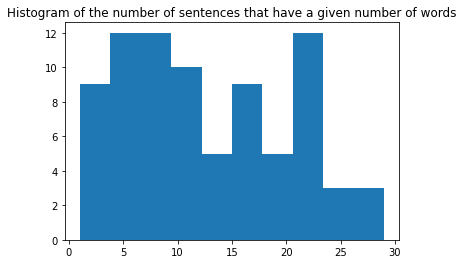

In [140]:
def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train);

In [141]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=20)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=20)

# RNN - embedding trained on corpus

Let's now feed this data to a Recurrent Neural Network.

model:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAVE TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

!`input_dim` should equal size of vocabulary + 1


Compile it with the appropriate arguments

In [142]:
embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model.add(layers.LSTM(20))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [143]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          36900     
                                                                 
 lstm_1 (LSTM)               (None, 20)                5680      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 42,801
Trainable params: 42,801
Non-trainable params: 0
_________________________________________________________________


In [144]:
#print(f'Expected number of parameters : {(vocab_size + 1) * embedding_dimension}')
es = EarlyStopping(patience=4, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=16,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 0.6907 - accuracy: 0.7321 - val_loss: 0.6963 - val_accuracy: 0.4167
Epoch 2/20
4/4 [==============================] - 0s 46ms/step - loss: 0.6828 - accuracy: 0.6964 - val_loss: 0.6984 - val_accuracy: 0.4167
Epoch 3/20
4/4 [==============================] - 0s 52ms/step - loss: 0.6735 - accuracy: 0.6964 - val_loss: 0.7011 - val_accuracy: 0.4167
Epoch 4/20
4/4 [==============================] - 0s 33ms/step - loss: 0.6606 - accuracy: 0.6964 - val_loss: 0.7064 - val_accuracy: 0.4167
Epoch 5/20
4/4 [==============================] - 0s 38ms/step - loss: 0.6408 - accuracy: 0.6964 - val_loss: 0.7139 - val_accuracy: 0.4167


In [ ]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

# NN Emebdding with Word2Vec - understanding

In [145]:
X_train

[['abusive',
  'relationship',
  'definitely',
  'abuse',
  'consensual',
  'man',
  'beats',
  'girlfriend',
  'wife',
  'bloody',
  'ask'],
 ["can't",
  'imagine',
  'trend',
  'isolated',
  'wall',
  'street',
  'seen',
  'mother',
  'hit',
  'glass',
  'ceiling',
  'many',
  'times',
  'unintended',
  'consequences',
  'troubling',
  'say',
  'least',
  'thankfully',
  'increased…'],
 ['maybe',
  'people',
  'finally',
  'listen',
  'us',
  'baptist',
  'ministers',
  'deacons',
  'others',
  'found',
  'guilty',
  'sex',
  'abuse',
  'report',
  'says'],
 ['farhan’s', 'first', 'five', 'minutes', 'gold'],
 ['ready',
  'pounce',
  'p',
  'ssy',
  'acosta',
  'man',
  'handling',
  'white',
  'house',
  'aid',
  'protecting',
  'assault',
  'thought',
  "that's",
  'p',
  'ssy',
  'hat',
  'wearing',
  'tutu',
  'twirling',
  'cry',
  'babies',
  'movement',
  'scream',
  'want'],
 ['📺', 'unsure', "she'll", 'watch', 'new'],
 ['nothing',
  'since',
  'hate',
  'back',
  'trying',
  'u

In [181]:
word2vec = Word2Vec(sentences=X_train)
wv = word2vec.wv
#wv["familiar"] --> in X_train but not wv??
size = len(wv['harassment'])
size

KeyError: "Key 'harassment' not present"

In [ ]:
wv.most_similar('harassment')
#word_embedding = wv[''harassment']
#wv.similar_by_vector(word_embedding)

In [ ]:
print('Vocabulary size', len(wv.key_to_index))
diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))

In a nutshell, this internal NN predicts a word from the surroundings words in a sentences. So it chooses many splits in the different sentences, choose some words as inputs  𝑋  and a word as output  𝑦  which it tries to predict, in the embedding space.

And as any neural network, Word2Vec has some hyperparameters.

## Word2Vec hyperparameters


The first important hyperparameter is the `vector_size` argument. It corresponds to the size of the embedding space. Learn a new `word2vec_2` model, still trained on the `X_train`, but with a smaller or higher `vector_size`.

Verify on some words that the corresponding embedding is of your selected size.

## vector_size

In [ ]:
word2vec_size30 = Word2Vec(sentences=X_train, vector_size = 30)
wv_size30 = word2vec_size30.wv
wv_size30.most_similar('harassment')

In [ ]:
# print('Vocabulary size', len(wv.key_to_index))
# diff_words = set([_ for elt in X_train for _ in elt])
# print('Number of different words in the train set', len(diff_words))

In [ ]:
word2vec_size50 = Word2Vec(sentences=X_train, vector_size = 50)
wv_size50 = word2vec_size50.wv
wv_size50.most_similar('harassment')

In [ ]:
word2vec_size100 = Word2Vec(sentences=X_train, vector_size = 100)
wv_size100 = word2vec_size100.wv
wv_size100.most_similar('harassment')

## min_count
Second hyperparameter `min_count`,  min # of times a word has to occur in order to be in embedding space

In [ ]:
# min_count:  min # of times a word has to occur in order to nbe in embedding space
word2vec3 = Word2Vec(sentences=X_train, vector_size = 30, min_count = 1)
wv3 = word2vec.wv
wv3.most_similar('harassment')

In [ ]:
## wv3["familiar"] -- > syill not in wv, why?
print('Vocabulary size', len(wv3.key_to_index))
diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))

In [ ]:
word2vec_0 = Word2Vec(sentences=X_train, vector_size=50, min_count=1)
word2vec_1 = Word2Vec(sentences=X_train, vector_size=50, min_count=2)
word2vec_2 = Word2Vec(sentences=X_train, vector_size=50, min_count=3)
word2vec_3 = Word2Vec(sentences=X_train, vector_size=50, min_count=5)
word2vec_4 = Word2Vec(sentences=X_train, vector_size=50, min_count=10)

In [ ]:
word2vec_1.wv["harassment"]
len(word2vec_1.wv.key_to_index)

In [ ]:
print(f'Number of word in W2V #1 : {len(word2vec_0.wv.key_to_index)}')
print(f'Number of word in W2V #1 : {len(word2vec_1.wv.key_to_index)}')
print(f'Number of word in W2V #2 : {len(word2vec_2.wv.key_to_index)}')
print(f'Number of word in W2V #3 : {len(word2vec_3.wv.key_to_index)}')
print(f'Number of word in W2V #4 : {len(word2vec_4.wv.key_to_index)}')

In [147]:
diff_words = set([_ for elt in X_train for _ in elt])
len(diff_words)

737

In [148]:
word2vec_3.wv.most_similar("harassment")

[('it’s', 0.3642662763595581),
 ('need', 0.27195632457733154),
 ('like', 0.19107677042484283),
 ('woman', 0.19076630473136902),
 ('abuse', 0.1906258761882782),
 ('news', 0.18562272191047668),
 ('hear', 0.18191683292388916),
 ('end', 0.17673398554325104),
 ('don’t', 0.1759101301431656),
 ('nothing', 0.1713448464870453)]

## window
The arguments you have seen (vector_size, min_count and window) are usually the one that you should start changing to get a better performance for your model.

Other hyperparameters in doc (cf 8.)

In [149]:
word2vec_3_window1 = Word2Vec(sentences=X_train, vector_size=50, min_count=3, window = 1)
word2vec_3 = Word2Vec(sentences=X_train, vector_size=50, min_count=3, window = 5) # default 5
word2vec_3_window8 = Word2Vec(sentences=X_train, vector_size=50, min_count=3, window = 8)

In [150]:
# print(f'Number of word in W2V #window 1 : {len(word2vec_3_window1 .wv.key_to_index)}')
# print(f'Number of word in W2V #window 5: {len(word2vec_3.wv.key_to_index)}')
# print(f'Number of word in W2V #window 8 : {len(word2vec_3_window8 .wv.key_to_index)}')

In [151]:
#word2vec_3_window1.wv.most_similar("harassment")

In [152]:
#word2vec_3.wv.most_similar("harassment") # default 5

In [153]:
#word2vec_3_window8.wv.most_similar("harassment")

# Embedding: convert W2V

Remember that word2vec is the first step to the overall process of feeding such a representation into a RNN, as shown here :

<img src="word2vec_representation.png" width="400px" />



Now, let's work on Step 2 by converting the training and test data into their vector representation to be ready to be feed in RNNs.

❓ **Question** ❓ Now, write a function that, given a sentence, returns a matrix that corresponds to the embedding of the full sentence, which means that you have to embed each word one after the other and concatenate the result to output a 2D matrix (be sure that your output is a NumPy array)

❗ **Remark** ❗ You will probably notice that some words you are trying to convert throw errors as they are said not to belong to the dictionary:

- for the test set, this is understandable: some words were not in the train set and thus their embedded representation is unknown
- for the train set, due to `min_count` hyperparameter, not all the words have a vector representation

In any case, just skip the missing words here.

## Embedding function

- each word --> vector w2v
- each sentence ---> matrix of w2v 
- e.g sentence of 5 words and embedding size 10 ---> matrix  5x10 --> # of words>=min_count x vector_size

In [166]:
def embed_sentence(word2vec, sentence):
    """ 
    sentence to matrix
    """
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)
   

def embedding(word2vec, sentences):
    """ 
    list(sentences in words)---> list(matrices)
    """
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [167]:
sentence = X_train[0]
word2vec = Word2Vec(sentences = X_train, vector_size=50, min_count = 2, window = 6)

print(embed_sentence(word2vec, sentence).shape)
#embed_sentence(word2vec, sentence)  ## --> 4 words in 50D --> 4x50 mx 

(3, 50)


In [168]:
X_train_embedded = embedding(word2vec, X_train)
print(type(X_train))
print(len(X_train), len(X_train_embedded))
print(f'dim of first sentence  {X_train_embedded[0].shape}')
print(f'dim of 2nd  sentence  {X_train_embedded[1].shape}')

<class 'list'>
80 80
dim of first sentence  (3, 50)
dim of 2nd  sentence  (6, 50)


## Padding

In order to have ready-to-use data, do not forget to pad them in order to have tensors that can be divided in batch sizes during the optimization. Store the padedd values in X_train_pad and X_test_pad. Do not forget the important arguments of the padding ;)

#! padding with zeros and in the end ?

In [176]:
# embedd
X_train_embedded = embedding(word2vec, X_train)
X_test_embedded = embedding(word2vec, X_train)

assert(len(X_train_embedded) == len(X_train))
len(X_train_embedded) # list of 80 matrices of xxx rows and 50 columns


80

In [178]:
# pad
X_train_pad = pad_sequences(X_train_embedded, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embedded, dtype='float32', padding='post')

assert(len(X_train_pad.shape) == 3)
X_train_pad.shape  ## array 80 matrices of 16x50 or 50x16? 
#!16 lmax length of senetnces in X_train

(80, 16, 50)

# Modelling NN

## Prep data

In [185]:
df.head()

,index,text,category
0,655324,"No dif between movement selectively denying a portion of society presumption of innocence and proper due process than what white mobs did blacks before lynching them, mob to Jap Americans in 1940's, or Nazis to Jews. You all belong to the same clubs...PATHETIC.",1
1,527150,International March\nHollywood CA lead by Indigenous People.,0
2,631941,Those last lines of “Lady Lazarus” have a blazing incantatory power. I find they come to mind when a new scandal breaks.,0
3,245725,will step up and stop working with ??\n,0
4,596593,", please let know if will be and worlds currency numeraire on 1/1/19.",0


In [186]:
df["category"].value_counts()

0    52
1    48
Name: category, dtype: int64

In [182]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)


for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

## Baseline model

In [191]:
unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)
print('Baseline accuracy: ', {1/2})
print('Acurracy to bit: ', {(4866 + 64190) / 74712})
#y_pred = 0 if counts[0] > counts[1] else 1
#print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))


Number of labels in train set {0: 39, 1: 41}
Baseline accuracy:  {0.5}
Acurracy to bit:  {0.9242959631652211}


## Initial RNN model 
use the NN model, and train with my data?


In [193]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [213]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 200, None)         0         
                                                                 
 lstm_4 (LSTM)               (None, 20)                5680      
                                                                 
 dense_8 (Dense)             (None, 15)                315       
                                                                 
 dense_9 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,011
Trainable params: 6,011
Non-trainable params: 0
_________________________________________________________________


In [194]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          batch_size = 32,  # low slower?
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

## accuracy 0.75

Epoch 1/100
2/2 [==============================] - 4s 903ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5417
Epoch 2/100
2/2 [==============================] - 0s 118ms/step - loss: 0.6930 - accuracy: 0.5893 - val_loss: 0.6917 - val_accuracy: 0.5417
Epoch 3/100
2/2 [==============================] - 0s 119ms/step - loss: 0.6925 - accuracy: 0.5536 - val_loss: 0.6909 - val_accuracy: 0.5417
Epoch 4/100
2/2 [==============================] - 0s 137ms/step - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5417
Epoch 5/100
2/2 [==============================] - 0s 123ms/step - loss: 0.6919 - accuracy: 0.5536 - val_loss: 0.6895 - val_accuracy: 0.5417
Epoch 6/100
2/2 [==============================] - 0s 138ms/step - loss: 0.6918 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.6667
Epoch 7/100
2/2 [==============================] - 0s 223ms/step - loss: 0.6912 - accuracy: 0.6429 - val_loss: 0.6883 - val_accuracy: 0.6667
Epoch 8/100
2

Epoch 59/100
2/2 [==============================] - 0s 133ms/step - loss: 0.6712 - accuracy: 0.6429 - val_loss: 0.6180 - val_accuracy: 0.6667
Epoch 60/100
2/2 [==============================] - 0s 133ms/step - loss: 0.6711 - accuracy: 0.6429 - val_loss: 0.6172 - val_accuracy: 0.6667
Epoch 61/100
2/2 [==============================] - 0s 124ms/step - loss: 0.6721 - accuracy: 0.6607 - val_loss: 0.6161 - val_accuracy: 0.6667
Epoch 62/100
2/2 [==============================] - 0s 121ms/step - loss: 0.6712 - accuracy: 0.6429 - val_loss: 0.6150 - val_accuracy: 0.6667
Epoch 63/100
2/2 [==============================] - 0s 132ms/step - loss: 0.6703 - accuracy: 0.6429 - val_loss: 0.6145 - val_accuracy: 0.6667
Epoch 64/100
2/2 [==============================] - 0s 131ms/step - loss: 0.6699 - accuracy: 0.6429 - val_loss: 0.6136 - val_accuracy: 0.6667
Epoch 65/100
2/2 [==============================] - 0s 360ms/step - loss: 0.6695 - accuracy: 0.6429 - val_loss: 0.6134 - val_accuracy: 0.6667
Epoch 

In [196]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 65.000%


## Improve RNN with transfer learning
use embedding done on other corpus 
Use trained NN with others data?

In [199]:
## list existing models (trained on >>>> data)
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [200]:
# pick glove-wiki-gigaword-50 for now, will try others--> teachers recommendation?
word2vec_transfer = api.load("glove-wiki-gigaword-50")

In [203]:
print(len(word2vec_transfer.key_to_index))
print(len(word2vec_transfer['harassment']))
word2vec_transfer['harassment']

400000
50


array([-0.24895 , -0.47437 , -0.68885 ,  0.36717 , -0.73489 ,  1.0981  ,
        1.0047  ,  0.39916 ,  0.010076, -0.5437  , -0.44854 , -0.6424  ,
       -0.41055 , -1.6133  ,  0.80873 , -0.63198 , -0.64017 , -0.26496 ,
        0.27235 , -0.5545  , -0.19271 ,  0.97283 , -0.18239 ,  0.35686 ,
       -0.55335 , -1.6031  ,  0.49933 , -0.38568 ,  0.35579 ,  0.31733 ,
        1.678   , -0.22731 , -0.19866 , -1.4406  , -0.92056 , -0.079727,
       -0.11499 , -1.7283  , -0.34006 ,  0.055786,  0.075179,  0.27707 ,
        0.52379 ,  1.3239  ,  0.79423 , -1.6663  , -0.048674,  0.55716 ,
       -0.13412 ,  0.28476 ], dtype=float32)

In [211]:
word2vec_transfer.most_similar('harrassment')

[('harrasment', 0.7795867919921875),
 ('harassment', 0.7719964385032654),
 ('favoritism', 0.7004265189170837),
 ('gender-based', 0.697039008140564),
 ('intimidation', 0.6910016536712646),
 ('coercion', 0.6858652234077454),
 ('antigay', 0.6821078062057495),
 ('misbehavior', 0.6813644170761108),
 ('victimisation', 0.6743680834770203),
 ('mistreatment', 0.6710280776023865)]

In [206]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

# Pad the training and test embedded sentences
X_train_pad_2 = pad_sequences(X_train_embed_2, dtype='float32', padding='post', maxlen=200)
X_test_pad_2 = pad_sequences(X_test_embed_2, dtype='float32', padding='post', maxlen=200)

In [215]:
# Run new model

es = EarlyStopping(patience=5, restore_best_weights=True)

model = init_model()


In [208]:
model.fit(X_train_pad_2, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )
## accuracy 0.7083

Epoch 1/100
2/2 [==============================] - 4s 922ms/step - loss: 0.6778 - accuracy: 0.6071 - val_loss: 0.6883 - val_accuracy: 0.5417
Epoch 2/100
2/2 [==============================] - 0s 143ms/step - loss: 0.6577 - accuracy: 0.7143 - val_loss: 0.6863 - val_accuracy: 0.5417
Epoch 3/100
2/2 [==============================] - 0s 135ms/step - loss: 0.6487 - accuracy: 0.6964 - val_loss: 0.6825 - val_accuracy: 0.5417
Epoch 4/100
2/2 [==============================] - 0s 128ms/step - loss: 0.6346 - accuracy: 0.7500 - val_loss: 0.6835 - val_accuracy: 0.5417
Epoch 5/100
2/2 [==============================] - 0s 133ms/step - loss: 0.6225 - accuracy: 0.7679 - val_loss: 0.6834 - val_accuracy: 0.5417
Epoch 6/100
2/2 [==============================] - 0s 139ms/step - loss: 0.6121 - accuracy: 0.7500 - val_loss: 0.6807 - val_accuracy: 0.5417
Epoch 7/100
2/2 [==============================] - 0s 127ms/step - loss: 0.6024 - accuracy: 0.7679 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 8/100
2

In [ ]:
model.summary()

In [210]:
res = model.evaluate(X_test_pad_2, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 70.000%


# Question to teachers

- Lementazing needed? yes--> reduce vocabulary_size in X_train
- Removing stop_words ---> yes.
- Why words in my X_train do not have embeddings with Word2Vec  --> depends on min_count
- keep (top 20) emojis by replacing with some word  instead of removing in data prep? 
- should we remove numbers in words? ex. "one"

- vector_size effect on embedding, not clear?---> seems like higher dimension better on most_similar words
-! transfer embedding vs "regular" embedding? 
TE = use pre-trained model to represent my data in N-dim
RE = use pre-defined NN to train on my data and represent in som N-dim ?

# Notes for myself

- !! some texts truncated example "yeah...." in sjekk
- remove "amp"--> stands for &
- Add confusion matrix

In [212]:
# plt.figure(figsize=(6,6))
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# sns.heatmap(cm, square=True, annot=True, cbar=False,
#             xticklabels=['non-hate', 'hate'], yticklabels=['non-hate', 'hate'])
# plt.xlabel('Predicted label')
# plt.ylabel('True label')

## Transfer learning vs "simple" embedding

- As mentionned ealier, Word2vec trains an internal Neural network whose goal is to predict a word in a corpus
based on the words around it. This part of the sentence is called the window.
Its size corresponds to the number of word around word W used to predict this word W

- Instead of learning it on your training set (especially if it is very small), you can directly 
load a pretrained embedding


# Keras documentation

- padding : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
- embedding: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2

# Gensim word2vec documentation

- https://radimrehurek.com/gensim/
- https://radimrehurek.com/gensim/models/word2vec.html#usage-examples
- https://radimrehurek.com/gensim/models/word2vec.html#usage-examples
- hyperparameters: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Text8Corpus
- transfer learning : gensim-data repository.

# To do

- twick Embedding hyperparameters to improve score
- Understand the other layers and hyperparameters to tune
- Improve data cleaning part (lemantizing?)
- Run all on bigger datasett
- ++++